# test_model

In [15]:
# torch utils
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data
import math
import copy
# from MITNet.MITNet import MITNet

# prot-bert tokenizer
from transformers import BertForMaskedLM, BertTokenizer, pipeline
from torch.nn.utils.rnn import pad_sequence

# data analysis
import pandas as pd
import matplotlib.pyplot as plt

# training
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
import tqdm

In [2]:
# run on gpu
if torch.cuda.is_available():
    device = torch.device("cuda")
    DEVICE_NAME = 'cuda'
    print("CUDA is available! Running on GPU.")
else:
    device = torch.device("cpu")
    DEVICE_NAME = 'cpu'
    print("CUDA is not available. Running on CPU.")

CUDA is available! Running on GPU.


## Our MITNet

In [3]:
class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        # Ensure that the model dimension (d_model) is divisible by the number of heads
        assert d_model % num_heads == 0, "d_model must be divisible by num_heads"
        
        # Initialize dimensions
        self.d_model = d_model # Model's dimension
        self.num_heads = num_heads # Number of attention heads
        self.d_k = d_model // num_heads # Dimension of each head's key, query, and value
        
        # Linear layers for transforming inputs
        self.W_q = nn.Linear(d_model, d_model) # Query transformation
        self.W_k = nn.Linear(d_model, d_model) # Key transformation
        self.W_v = nn.Linear(d_model, d_model) # Value transformation
        self.W_o = nn.Linear(d_model, d_model) # Output transformation
        
    def scaled_dot_product_attention(self, Q, K, V, mask=None):
        # Calculate attention scores
        attn_scores = torch.matmul(Q, K.transpose(-2, -1)) / math.sqrt(self.d_k)
        
        # Apply mask if provided (useful for preventing attention to certain parts like padding)
        if mask is not None:
            attn_scores = attn_scores.masked_fill(mask == 0, -1e9)
        
        # Softmax is applied to obtain attention probabilities
        attn_probs = torch.softmax(attn_scores, dim=-1)
        
        # Multiply by values to obtain the final output
        output = torch.matmul(attn_probs, V)
        return output
        
    def split_heads(self, x):
        # Reshape the input to have num_heads for multi-head attention
        batch_size, seq_length, d_model = x.size()
        return x.view(batch_size, seq_length, self.num_heads, self.d_k).transpose(1, 2)
        
    def combine_heads(self, x):
        # Combine the multiple heads back to original shape
        batch_size, _, seq_length, d_k = x.size()
        return x.transpose(1, 2).contiguous().view(batch_size, seq_length, self.d_model)
        
    def forward(self, Q, K, V, mask=None):
        # Apply linear transformations and split heads
        Q = self.split_heads(self.W_q(Q))
        K = self.split_heads(self.W_k(K))
        V = self.split_heads(self.W_v(V))
        
        # Perform scaled dot-product attention
        attn_output = self.scaled_dot_product_attention(Q, K, V, mask)
        
        # Combine heads and apply output transformation
        output = self.W_o(self.combine_heads(attn_output))
        return output
    
# NOTE: Redefine FF for MITNet
class CovFeedForward(nn.Module):
    def __init__(self, d_model, d_ff, in_channel, eps = 1e-6, dropout=0.2, ):
        super(CovFeedForward, self).__init__()
        self.norm1 = nn.LayerNorm(d_model, eps=eps)
        # First convolutional filters, kernel size and activation: 4, 1, 'relu'
        self.cov1 = nn.Conv1d(in_channel, d_ff, kernel_size=1)
        # Second convolutional filters and kernel size: number of channel inputs, 1
        self.cov2 = nn.Conv1d(d_ff, in_channel, kernel_size=1)
        self.channel_input = d_ff
        self.dropout = nn.Dropout(dropout)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        # Layer normalization
        x = self.norm1(x)
        # First convolutional layer
        x = self.cov1(x)
        # ReLU activation
        x = self.relu(x)
        # Dropout
        x = self.dropout(x)
        # Second convolutional layer
        x = self.cov2(x)
        return x

In [4]:
# NOTE: transformer block in figure 4
class TransformerBlock(nn.Module):
    def __init__(self, d_model, num_heads, d_ff, in_channel, dropout=0.25, eps=1e-6):
        super(TransformerBlock, self).__init__()
        self.norm1 = nn.LayerNorm(d_model, eps=eps)
        self.self_attn = MultiHeadAttention(d_model, num_heads)
        self.dropout = nn.Dropout(dropout)
        self.cov_ff = CovFeedForward(d_model, d_ff, in_channel, eps=1e-6, dropout=0.2)
    
    def forward(self, x, mask):
        res = x
        # Layer normalization
        x = self.norm1(x)
        # Multihead Attention
        x = self.self_attn(x, x, x, mask)
        # Dropout
        x = self.dropout(x)
        x += res

        # FeedFoward
        res = x
        x = self.cov_ff(x)
        return x + res
    
class ClassificationBlock(nn.Module):
    def __init__(self, input_dim, dropout, output_class=2, hidden_dim=128):
        super(ClassificationBlock, self).__init__()
        # TODO: 
        self.global_avg_pooling = nn.AdaptiveAvgPool1d(1)  # Global Average Pooling
        self.mlp1 = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),  # MLP Layer 1
            nn.ReLU(),
            nn.Dropout(dropout)
        )
        self.mlp2 = nn.Linear(hidden_dim, output_class)  # Output MLP
        
    def forward(self, x):
        # Global Average Pooling
        out = self.global_avg_pooling(x.permute(0, 2, 1)).squeeze(2) 
        # MLP
        out = self.mlp1(out)
        # Output MLP
        out = self.mlp2(out)
        return F.softmax(out, dim=1)  # Softmax activation for classification
    
class TransformerMITNet(nn.Module):
    def __init__(self, src_vocab_size, d_model, num_heads, num_layers, d_ff, in_channel, trans_dropout, class_dropout, max_seq_length=64):
        super(TransformerMITNet, self).__init__()
        '''
        Transformer head MITNet:
        (1) Embedding (one-hot/our choice)
        (2) Transformer blocks * 4
        (3) Classification block
        '''
        # TODO: replace this with our own encoding method
        self.embedding = nn.Embedding(src_vocab_size, d_model)
        # NOTE: may not need positional encoding for our project
        # self.positional_encoding = PositionalEncoding(d_model, max_seq_length)

        # Transformer blocks
        self.transformer_blocks = nn.ModuleList([TransformerBlock(d_model, num_heads, d_ff, in_channel, dropout=trans_dropout) for _ in range(num_layers)])
        # Classification
        self.classification_block = ClassificationBlock(d_model, dropout=class_dropout, output_class=2, hidden_dim=128)

    def generate_mask(self, src):
        src_mask = (src != torch.tensor(0, dtype=src.dtype)).unsqueeze(1).unsqueeze(2)
        return src_mask
    
    def forward(self, src):
        # src_embedded = self.positional_encoding(self.encoder_embedding(src))
        src_embedded = self.embedding(src)
        src_mask = self.generate_mask(src)
        tran_output = src_embedded
        for tran_layer in self.transformer_blocks:
            tran_output = tran_layer(tran_output, src_mask)
        return self.classification_block(tran_output)

In [5]:
class DenseLayer(nn.Module):
    def __init__(self, input_dim, hidden_dims=[16, 64, 16]):
        super(DenseLayer, self).__init__()
        self.dense_1 = nn.Linear(input_dim, hidden_dims[0])
        self.dense_2 = nn.Linear(hidden_dims[0],  hidden_dims[1])
        self.dense_3 = nn.Linear(hidden_dims[1],  hidden_dims[2])
        self.activation = nn.LeakyReLU()
    
    def forward(self, x):
        x = self.activation(self.dense_1(x))
        x = self.activation(self.dense_2(x))
        x = self.activation(self.dense_3(x))
        return x

class DenseNetwork(nn.Module):
    def __init__(self, input_dim, n_stack=1, hidden_dims=[16, 64, 16]):
        super(DenseNetwork, self).__init__()
        self.DenseNet = nn.ModuleList([DenseLayer(input_dim, hidden_dims) for _ in range(n_stack)])
        self.BatchNorm = nn.BatchNorm1d(hidden_dims[-1])

    def forward(self, x):
        for module in self.DenseNet:
            x = module(x)
        x = self.BatchNorm(x)
        return x

In [6]:
class ClassificationNet(nn.Module):
    def __init__(self, input_dim, hidden_dim=2):
        super(ClassificationNet, self).__init__()
        self.dense = nn.Linear(input_dim, hidden_dim)
        self.output = nn.Softmax(dim=1)
    
    def forward(self, x):
        return self.output(self.dense(x))

In [7]:
class MITNet(nn.Module):
    def __init__(self, src_vocab_size, in_channel, d_model=32, num_heads=4, num_layers=4, d_ff=4, trans_dropout=0.25, class_dropout=0.1):
        super(MITNet, self).__init__()
        # transformer: output class 0 or 1
        self.transformer = TransformerMITNet(src_vocab_size, d_model, num_heads, num_layers, d_ff, in_channel, trans_dropout, class_dropout)
        # dense network
        self.dense = DenseNetwork(input_dim=2, n_stack=1, hidden_dims=[16, 64, 16])
        # classification network: input 16, output 2
        self.classification = ClassificationNet(input_dim=16, hidden_dim=2)

    def forward(self, x):
        x = self.transformer(x)
        x = self.dense(x)
        return self.classification(x)

## Cleaned dataset

In [9]:
# Load the CSV file
file_path = "clean_data.csv"
data = pd.read_csv(file_path)

# Display the first few rows of the loaded data
print(data.shape)

(5503, 24)


In [10]:
data.head(5)

,Epitope - Name,Assay - Qualitative Measure,Epitope - Object Type,Epitope - Starting Position,Epitope - Ending Position,Epitope - Source Molecule,Epitope - Source Organism,Host - Name,Host - Age,1st in vivo Process - Process Type,...,Assay - Response measured,Assay - Response Frequency (%),Assay Antibody - Antibody Source Material,Assay Antibody - Immunoglobulin Domain,Assay Antibody - Purification Status,Assay Antibody - Heavy chain isotype,Assay Antigen - Epitope Relation,Assay Antigen - Object Type,Assay Antigen - Source Organism,Assay Antigen - Species
0,PTRAETREERMERKRREKIE,1,Linear peptide,57.0,76.0,U1 small nuclear ribonucleoprotein 70 kDa,Homo sapiens,Homo sapiens,Seniors (65+ years),Occurrence of autoimmune disease,...,qualitative binding,NaN,Serum,NaN,Polyclonal,NaN,Epitope,Linear peptide,Homo sapiens,Homo sapiens
1,ERKRR,1,Linear peptide,68.0,72.0,U1 small nuclear ribonucleoprotein 70 kDa,Homo sapiens,Homo sapiens,Seniors (65+ years),Occurrence of autoimmune disease,...,qualitative binding,NaN,Serum,NaN,Polyclonal,NaN,Epitope,Linear peptide,Homo sapiens,Homo sapiens
2,ERKRR,1,Linear peptide,68.0,72.0,U1 small nuclear ribonucleoprotein 70 kDa,Homo sapiens,Homo sapiens,Seniors (65+ years),Occurrence of autoimmune disease,...,qualitative binding,NaN,Serum,NaN,Polyclonal,NaN,Other,Protein,Influenza B virus (B/Singapore/222/79),Influenza B virus
3,AEEEEDDDMGFGLFD,1,Linear peptide,93.0,107.0,ribosomal protein P-JL5,Trypanosoma cruzi,Homo sapiens,Seniors (65+ years),Occurrence of autoimmune disease,...,qualitative binding,100.0,Serum,Entire Antibody,Polyclonal,IgG,Epitope,Linear peptide,Trypanosoma cruzi,Trypanosoma cruzi
4,ASAPTAAAAASGGAAAPAA,0,Linear peptide,73.0,91.0,ribosomal protein P-JL5,Trypanosoma cruzi,Homo sapiens,Seniors (65+ years),Occurrence of autoimmune disease,...,qualitative binding,0.0,Serum,Entire Antibody,Polyclonal,IgG,Epitope,Linear peptide,Trypanosoma cruzi,Trypanosoma cruzi


In [11]:
target_col = "Assay - Qualitative Measure"
feature_col = "Epitope - Name"
filtered_df = data[[feature_col, target_col]]
filtered_df.head(5)

,Epitope - Name,Assay - Qualitative Measure
0,PTRAETREERMERKRREKIE,1
1,ERKRR,1
2,ERKRR,1
3,AEEEEDDDMGFGLFD,1
4,ASAPTAAAAASGGAAAPAA,0


In [12]:
# # self tokenizer
# from torch.nn.utils.rnn import pad_sequence

# amino_acids = "ACDEFGHIKLMNPQRSTVWY"  # List of amino acids
# vocab = {amino: i+1 for i, amino in enumerate(amino_acids)}  # Mapping amino acids to tokens
# vocab_size = len(vocab) + 1  # Add 1 for padding token
# pad_token = 0
# def tokenize(sequence, vocab):
#     return [vocab.get(aa, vocab_size) for aa in sequence]

# # Tokenize sequences
# filtered_df['Tokenized_Epitope'] = filtered_df['Epitope - Name'].apply(lambda x: tokenize(x, vocab))
# pad_sequences = pad_sequence([torch.tensor(seq) for seq in filtered_df['Tokenized_Epitope']], padding_value=pad_token, batch_first=True)

In [13]:
print(filtered_df['Epitope - Name'][0])
print(" ".join(filtered_df['Epitope - Name'][0]))
tokenizer = BertTokenizer.from_pretrained("Rostlab/prot_bert", do_lower_case=False )
tokenizer(" ".join(filtered_df['Epitope - Name'][0]))

PTRAETREERMERKRREKIE
P T R A E T R E E R M E R K R R E K I E


tokenizer_config.json:   0%|          | 0.00/86.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/81.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/361 [00:00<?, ?B/s]

{'input_ids': [2, 16, 15, 13, 6, 9, 15, 13, 9, 9, 13, 21, 9, 13, 12, 13, 13, 9, 12, 11, 9, 3], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

In [19]:
# pro_bert tokenizer
filtered_df['Tokenized_Epitope'] = filtered_df['Epitope - Name'].apply(lambda x: tokenizer(" ".join(x))['input_ids'])
pad_sequences = pad_sequence([torch.tensor(seq) for seq in filtered_df['Tokenized_Epitope']], padding_value=tokenizer.vocab["[PAD]"], batch_first=True)

In [20]:
pad_sequences.shape

torch.Size([5503, 27])

In [21]:
# test
src_vocab_size = len(tokenizer.vocab)
in_channel = pad_sequences.shape[1]
model = MITNet(src_vocab_size, in_channel)
pred = model(pad_sequences)

In [24]:
# label_mapping = {'Positive': 1, 'Negative': 0}
# filtered_df['Label'] = filtered_df['Assay - Qualitative Measurement'].map(label_mapping)
target_tensor = torch.tensor(filtered_df["Assay - Qualitative Measure"].values, dtype=torch.long)

In [23]:
# filtered_df.to_csv("tokenized_labelled_tcell.csv")

## Training Experiment I

Training details:
* Optimizer Adam: lr = 1e-4
* Training Epochs: 80
* Loss Function: Cross Entropy Loss
* Traing validation split: 8:2
* Batch Size: 16

In [69]:
src_vocab_size = len(tokenizer.vocab)
in_channel = pad_sequences.shape[1]
# change to cuda
model = MITNet(src_vocab_size, in_channel).to(device)
target_tensor = target_tensor.to(device)
pad_sequences = pad_sequences.to(device)

# Define your loss function and optimizer
criterion = nn.CrossEntropyLoss()
learning_rate = 1e-4
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Create a TensorDataset
dataset = TensorDataset(pad_sequences, target_tensor)


# Split dataset into training and validation sets
train_indices, val_indices = train_test_split(range(len(dataset)), test_size=0.2, random_state=42)

batch_size = 16
# Create DataLoader for training set
train_sampler = torch.utils.data.SubsetRandomSampler(train_indices)
train_loader = DataLoader(dataset, batch_size=batch_size, sampler=train_sampler)
# Create DataLoader for validation set
val_sampler = torch.utils.data.SubsetRandomSampler(val_indices)
val_loader = DataLoader(dataset, batch_size=batch_size, sampler=val_sampler)


In [70]:
# Training loop
num_epochs = 80
training_loss_list = []
training_acc_list = []
for epoch in range(num_epochs):
    running_loss = 0.0
    correct_predictions = 0
    total_samples = 0
    
    for inputs, labels in train_loader:
        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)

        # Compute the loss
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        # Update running loss
        running_loss += loss.item()

        # Calculate training accuracy
        _, predicted = torch.max(outputs, 1)
        correct_predictions += (predicted == labels).sum().item()
        total_samples += labels.size(0)
    
    epoch_loss = running_loss / len(train_loader)
    epoch_accuracy = correct_predictions / total_samples
    training_loss_list.append(epoch_loss)
    training_acc_list.append(epoch_accuracy)
    if epoch%5==0:
        print(f'Epoch {epoch+1}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.4f}')

print('Training finished')

Epoch 1, Loss: 0.6397, Accuracy: 0.6786
Epoch 6, Loss: 0.4994, Accuracy: 0.8224
Epoch 11, Loss: 0.4755, Accuracy: 0.8396
Epoch 16, Loss: 0.4631, Accuracy: 0.8496
Epoch 21, Loss: 0.4595, Accuracy: 0.8544
Epoch 26, Loss: 0.4570, Accuracy: 0.8539
Epoch 31, Loss: 0.4515, Accuracy: 0.8601
Epoch 36, Loss: 0.4500, Accuracy: 0.8614
Epoch 41, Loss: 0.4537, Accuracy: 0.8587
Epoch 46, Loss: 0.4443, Accuracy: 0.8694
Epoch 51, Loss: 0.4430, Accuracy: 0.8696
Epoch 56, Loss: 0.4409, Accuracy: 0.8705
Epoch 61, Loss: 0.4409, Accuracy: 0.8705
Epoch 66, Loss: 0.4391, Accuracy: 0.8719
Epoch 71, Loss: 0.4375, Accuracy: 0.8746
Epoch 76, Loss: 0.4343, Accuracy: 0.8778
Training finished


Text(0.5, 0, 'Epochs')

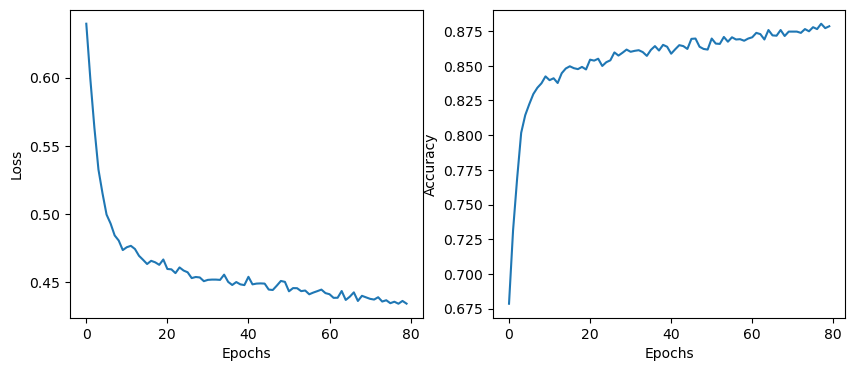

In [71]:
# plot loss vs epochs
fig = plt.figure(figsize = (10, 4))
ax = fig.add_subplot(1, 2, 1)
ax.plot(range(num_epochs), training_loss_list)
ax.set_ylabel('Loss')
ax.set_xlabel('Epochs')

ax = fig.add_subplot(1, 2, 2)
ax.plot(range(num_epochs), training_acc_list)
ax.set_ylabel('Accuracy')
ax.set_xlabel('Epochs')

In [72]:
from sklearn.metrics import roc_auc_score, f1_score

# Evaluation function
def evaluate(model, dataloader):
    model.eval()
    correct_predictions = 0
    total_samples = 0
    all_labels = []
    all_preds = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            correct_predictions += (predicted == labels).sum().item()
            total_samples += labels.size(0)

            all_labels.extend(labels.tolist())
            all_preds.extend(predicted.tolist())

    accuracy = correct_predictions / total_samples
    roc_auc = roc_auc_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds)

    return accuracy, roc_auc, f1

# Perform validation
val_accuracy, val_roc_auc, val_f1 = evaluate(model, val_loader)

print(f'Validation Accuracy: {val_accuracy:.4f}')
print(f'ROC AUC Score: {val_roc_auc:.4f}')
print(f'F1 Score: {val_f1:.4f}')


Validation Accuracy: 0.8565
ROC AUC Score: 0.7849
F1 Score: 0.7063


In [73]:
performance = {}
performance["CTClassifier-Adam"]={
    "Accuracy": val_accuracy,
    "ROC-AUC Score":val_roc_auc,
    "F1 Score": val_f1
    }

## Training Experiment II

Training details:
* Optimizer AdamW: lr = 1e-4, weight decay = 1e-5
* Training Epochs: 100
* Loss Function: Cross Entropy Loss
* Traing validation split: 8:2
* Batch Size: 16

In [80]:
src_vocab_size = len(tokenizer.vocab)
in_channel = pad_sequences.shape[1]
# change to cuda
model = MITNet(src_vocab_size, in_channel).to(device)
target_tensor = target_tensor.to(device)
pad_sequences = pad_sequences.to(device)

# Define your loss function and optimizer
criterion = nn.CrossEntropyLoss()
learning_rate = 1e-4
optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=1e-5)

# Create a TensorDataset
dataset = TensorDataset(pad_sequences, target_tensor)


# Split dataset into training and validation sets
train_indices, val_indices = train_test_split(range(len(dataset)), test_size=0.2, random_state=42)

batch_size = 16
# Create DataLoader for training set
train_sampler = torch.utils.data.SubsetRandomSampler(train_indices)
train_loader = DataLoader(dataset, batch_size=batch_size, sampler=train_sampler)
# Create DataLoader for validation set
val_sampler = torch.utils.data.SubsetRandomSampler(val_indices)
val_loader = DataLoader(dataset, batch_size=batch_size, sampler=val_sampler)

In [81]:
# Training loop
num_epochs = 100
training_loss_list = []
training_acc_list = []
for epoch in range(num_epochs):
    running_loss = 0.0
    correct_predictions = 0
    total_samples = 0
    
    for inputs, labels in train_loader:
        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)

        # Compute the loss
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        # Update running loss
        running_loss += loss.item()

        # Calculate training accuracy
        _, predicted = torch.max(outputs, 1)
        correct_predictions += (predicted == labels).sum().item()
        total_samples += labels.size(0)
    
    epoch_loss = running_loss / len(train_loader)
    epoch_accuracy = correct_predictions / total_samples
    training_loss_list.append(epoch_loss)
    training_acc_list.append(epoch_accuracy)
    if epoch%5==0:
        print(f'Epoch {epoch+1}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.4f}')

print('Training finished')

Epoch 1, Loss: 0.6693, Accuracy: 0.5881
Epoch 6, Loss: 0.4929, Accuracy: 0.8321
Epoch 11, Loss: 0.4728, Accuracy: 0.8430
Epoch 16, Loss: 0.4627, Accuracy: 0.8507
Epoch 21, Loss: 0.4609, Accuracy: 0.8521
Epoch 26, Loss: 0.4587, Accuracy: 0.8542
Epoch 31, Loss: 0.4579, Accuracy: 0.8539
Epoch 36, Loss: 0.4552, Accuracy: 0.8562
Epoch 41, Loss: 0.4528, Accuracy: 0.8619
Epoch 46, Loss: 0.4528, Accuracy: 0.8612
Epoch 51, Loss: 0.4500, Accuracy: 0.8619
Epoch 56, Loss: 0.4463, Accuracy: 0.8664
Epoch 61, Loss: 0.4482, Accuracy: 0.8637
Epoch 66, Loss: 0.4479, Accuracy: 0.8651
Epoch 71, Loss: 0.4442, Accuracy: 0.8673
Epoch 76, Loss: 0.4415, Accuracy: 0.8712
Epoch 81, Loss: 0.4408, Accuracy: 0.8712
Epoch 86, Loss: 0.4386, Accuracy: 0.8741
Epoch 91, Loss: 0.4414, Accuracy: 0.8728
Epoch 96, Loss: 0.4377, Accuracy: 0.8757
Training finished


Text(0.5, 0, 'Epochs')

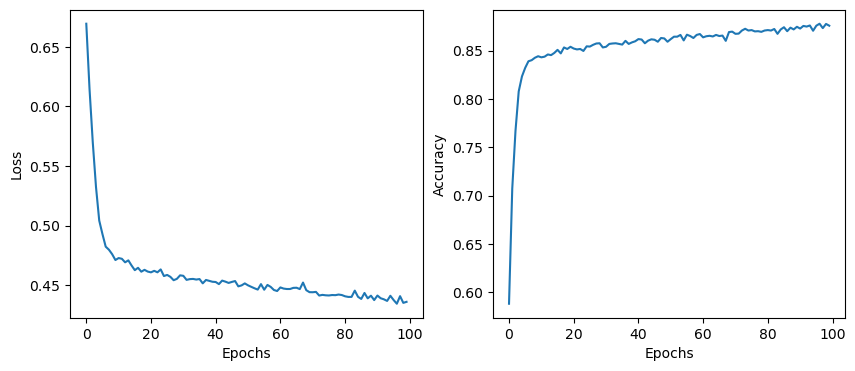

In [82]:
# plot loss vs epochs
fig = plt.figure(figsize = (10, 4))
ax = fig.add_subplot(1, 2, 1)
ax.plot(range(num_epochs), training_loss_list)
ax.set_ylabel('Loss')
ax.set_xlabel('Epochs')

ax = fig.add_subplot(1, 2, 2)
ax.plot(range(num_epochs), training_acc_list)
ax.set_ylabel('Accuracy')
ax.set_xlabel('Epochs')

In [83]:
# Perform validation
val_accuracy, val_roc_auc, val_f1 = evaluate(model, val_loader)

print(f'Validation Accuracy: {val_accuracy:.4f}')
print(f'ROC AUC Score: {val_roc_auc:.4f}')
print(f'F1 Score: {val_f1:.4f}')

Validation Accuracy: 0.8583
ROC AUC Score: 0.7872
F1 Score: 0.7100


In [84]:
performance["CTClassifier-AdamW"]={
    "Accuracy": val_accuracy,
    "ROC-AUC Score":val_roc_auc,
    "F1 Score": val_f1
    }

In [86]:
performance_ctc_base = pd.DataFrame(performance)

In [91]:
performance_ctc_base.rename(columns = {
    "CTClassifier-Adam": "MITNet-Adam",
    "CTClassifier-AdamW": "MITNet-AdamW"}, inplace=True)

In [92]:
performance_ctc_base.to_csv("performance_ctc_base.csv")

In [95]:
# save model
torch.save(model.state_dict(), 'mitnet_adamw_model.pth')

In [98]:
# load model
src_vocab_size = len(tokenizer.vocab)
in_channel = pad_sequences.shape[1]
model = MITNet(src_vocab_size, in_channel).to(device)

# Load the model's state dict from the saved file
model.load_state_dict(torch.load('mitnet_adamw_model.pth'))

# Put the model in evaluation mode
val_accuracy, val_roc_auc, val_f1 = evaluate(model, val_loader)

print(f'Validation Accuracy: {val_accuracy:.4f}')
print(f'ROC AUC Score: {val_roc_auc:.4f}')
print(f'F1 Score: {val_f1:.4f}')

Validation Accuracy: 0.8583
ROC AUC Score: 0.7872
F1 Score: 0.7100
